# ETL Pipeline Preparation
Follow the instructions below to help you create your ETL pipeline.
### 1. Import libraries and load datasets.
- Import Python libraries
- Load `messages.csv` into a dataframe and inspect the first few lines.
- Load `categories.csv` into a dataframe and inspect the first few lines.

In [90]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [91]:
# load messages dataset
messages = pd.read_csv('data/disaster_messages.csv')
messages.head(3)

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct


In [92]:
# load categories dataset
categories = pd.read_csv('data/disaster_categories.csv')
categories.head(3)

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...


### 2. Merge datasets.
- Merge the messages and categories datasets using the common id
- Assign this combined dataset to `df`, which will be cleaned in the following steps

In [93]:
# merge datasets
df = pd.merge(messages, categories, how='inner')
df = df.drop_duplicates(subset = 'id')
df.head(3)

,id,message,original,genre,categories
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,related-1;request-0;offer-0;aid_related-0;medi...
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,related-1;request-0;offer-0;aid_related-1;medi...
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,related-1;request-0;offer-0;aid_related-0;medi...


### 3. Split `categories` into separate category columns.
- Split the values in the `categories` column on the `;` character so that each value becomes a separate column. You'll find [this method](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.Series.str.split.html) very helpful! Make sure to set `expand=True`.
- Use the first row of categories dataframe to create column names for the categories data.
- Rename columns of `categories` with new column names.

In [94]:
categories = df.categories.str.split(';', expand = True)
new_names = pd.Series(categories.loc[0].values).str.split('-', expand = True)[0].values
new_names = dict(zip(np.arange(categories.shape[0]), new_names))
categories = categories.rename(columns = new_names)

### 4. Convert category values to just numbers 0 or 1.
- Iterate through the category columns in df to keep only the last character of each string (the 1 or 0). For example, `related-0` becomes `0`, `related-1` becomes `1`. Convert the string to a numeric value.
- You can perform [normal string actions on Pandas Series](https://pandas.pydata.org/pandas-docs/stable/text.html#indexing-with-str), like indexing, by including `.str` after the Series. You may need to first convert the Series to be of type string, which you can do with `astype(str)`.

In [95]:
for column in categories:
    # set each value to be the last character of the string
    # using regex from https://stackoverflow.com/questions/37683558/pandas-extract-number-from-string
    categories[column] = categories[column].str.extract('(\d+)').astype(int)
    
categories.head(3)

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 5. Replace `categories` column in `df` with new category columns.
- Drop the categories column from the df dataframe since it is no longer needed.
- Concatenate df and categories data frames.

In [96]:
# drop the original categories column from `df`
df = df.drop(columns = 'categories')
# concatenate the original dataframe with the new `categories` dataframe
df = pd.concat([df, categories], axis = 1)
df.head(3)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's first see if there's anything wrong with those numerical values.

In [97]:
categories.describe()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.0,...,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000,26180.000000
mean,0.773568,0.170512,0.004507,0.414095,0.079488,0.050076,0.027655,0.017991,0.032811,0.0,...,0.011803,0.043965,0.278304,0.082086,0.093201,0.010772,0.093659,0.020168,0.052559,0.193430
std,0.435351,0.376089,0.066986,0.492574,0.270504,0.218107,0.163985,0.132920,0.178146,0.0,...,0.108000,0.205021,0.448172,0.274500,0.290719,0.103228,0.291360,0.140578,0.223156,0.394995
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can spot something is wrong with the 'related' label as the max value 2 appears. 

In [98]:
df[df['related'] > 1].head(2)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
117,146,Dans la zone de Saint Etienne la route de Jacm...,Nan zon st. etine rout jakmel la bloke se mize...,direct,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
221,263,. .. i with limited means. Certain patients co...,t avec des moyens limites. Certains patients v...,direct,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's now try to figure out what do these labels mean and see if we can fix them.

In [99]:
# total entries with wrong labels
(categories['related'] > 1).sum()

188

The sum of other labels of each anomalous row:

In [100]:
a_rows = categories[categories['related'] > 1].drop(columns = 'related')
a_rows.sum(axis=1).max(), a_rows.sum(axis=1).min()

(0, 0)

We see that for those rows with 'related' = 2, all other labels are 0. Hence we conclude that the original label 'related-2' actually means 'related-0'. Then we can correct them:

In [101]:
df.loc[df['related'] > 1,'related'] = 0 # set labels 2 to 0
categories = df.drop(columns = ['id', 'message', 'original', 'genre'])

We now check the distribution of the length of messages.

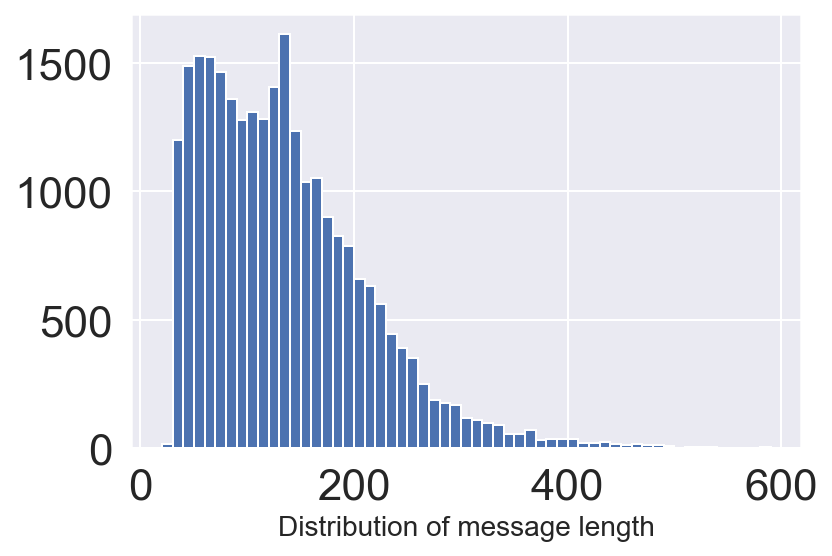

In [102]:
lens = df.message.str.len()
lens.hist(bins = np.arange(20,600,10))
plt.xlabel('Distribution of message length', fontsize = 14)
plt.show()

In [103]:
lens.mode(), lens.median(), lens.quantile(0.8)

(0    137
 dtype: int64,
 124.0,
 195.0)

We can see the length of most messages are lesss than 200 words. A funny fact is the mode and median of the length distribution seems to be affected by the twitter length constraint (144 words).

While there are also some very long messages:

In [104]:
# length of 20 longest messages
lens.sort_values().values[-20:]

array([ 3963,  4011,  4102,  4151,  4153,  4227,  4236,  4746,  4769,
        5052,  5149,  5451,  5783,  6144,  6313,  6510,  6936,  6951,
       10571, 10818])

As expected, most of these (18 out of 20) messages are news.

In [105]:
df[df['id'].isin(lens.sort_values(ascending = False).index.values[:20])].genre

12157    direct
12876    social
13461      news
13532      news
13640      news
14383      news
14792      news
14835      news
16729      news
17857      news
17875      news
18247      news
19287      news
19905      news
21663      news
21774      news
21923      news
Name: genre, dtype: object

In [ ]:
# delete two longest outliers
# df = df[~df['id'].isin(lens.sort_values().index.values[-2:])]
# categories = df.drop(columns = ['id', 'message', 'original', 'genre'])

Now let's do more visualizations for the data. Code adapted from this [post](https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff).

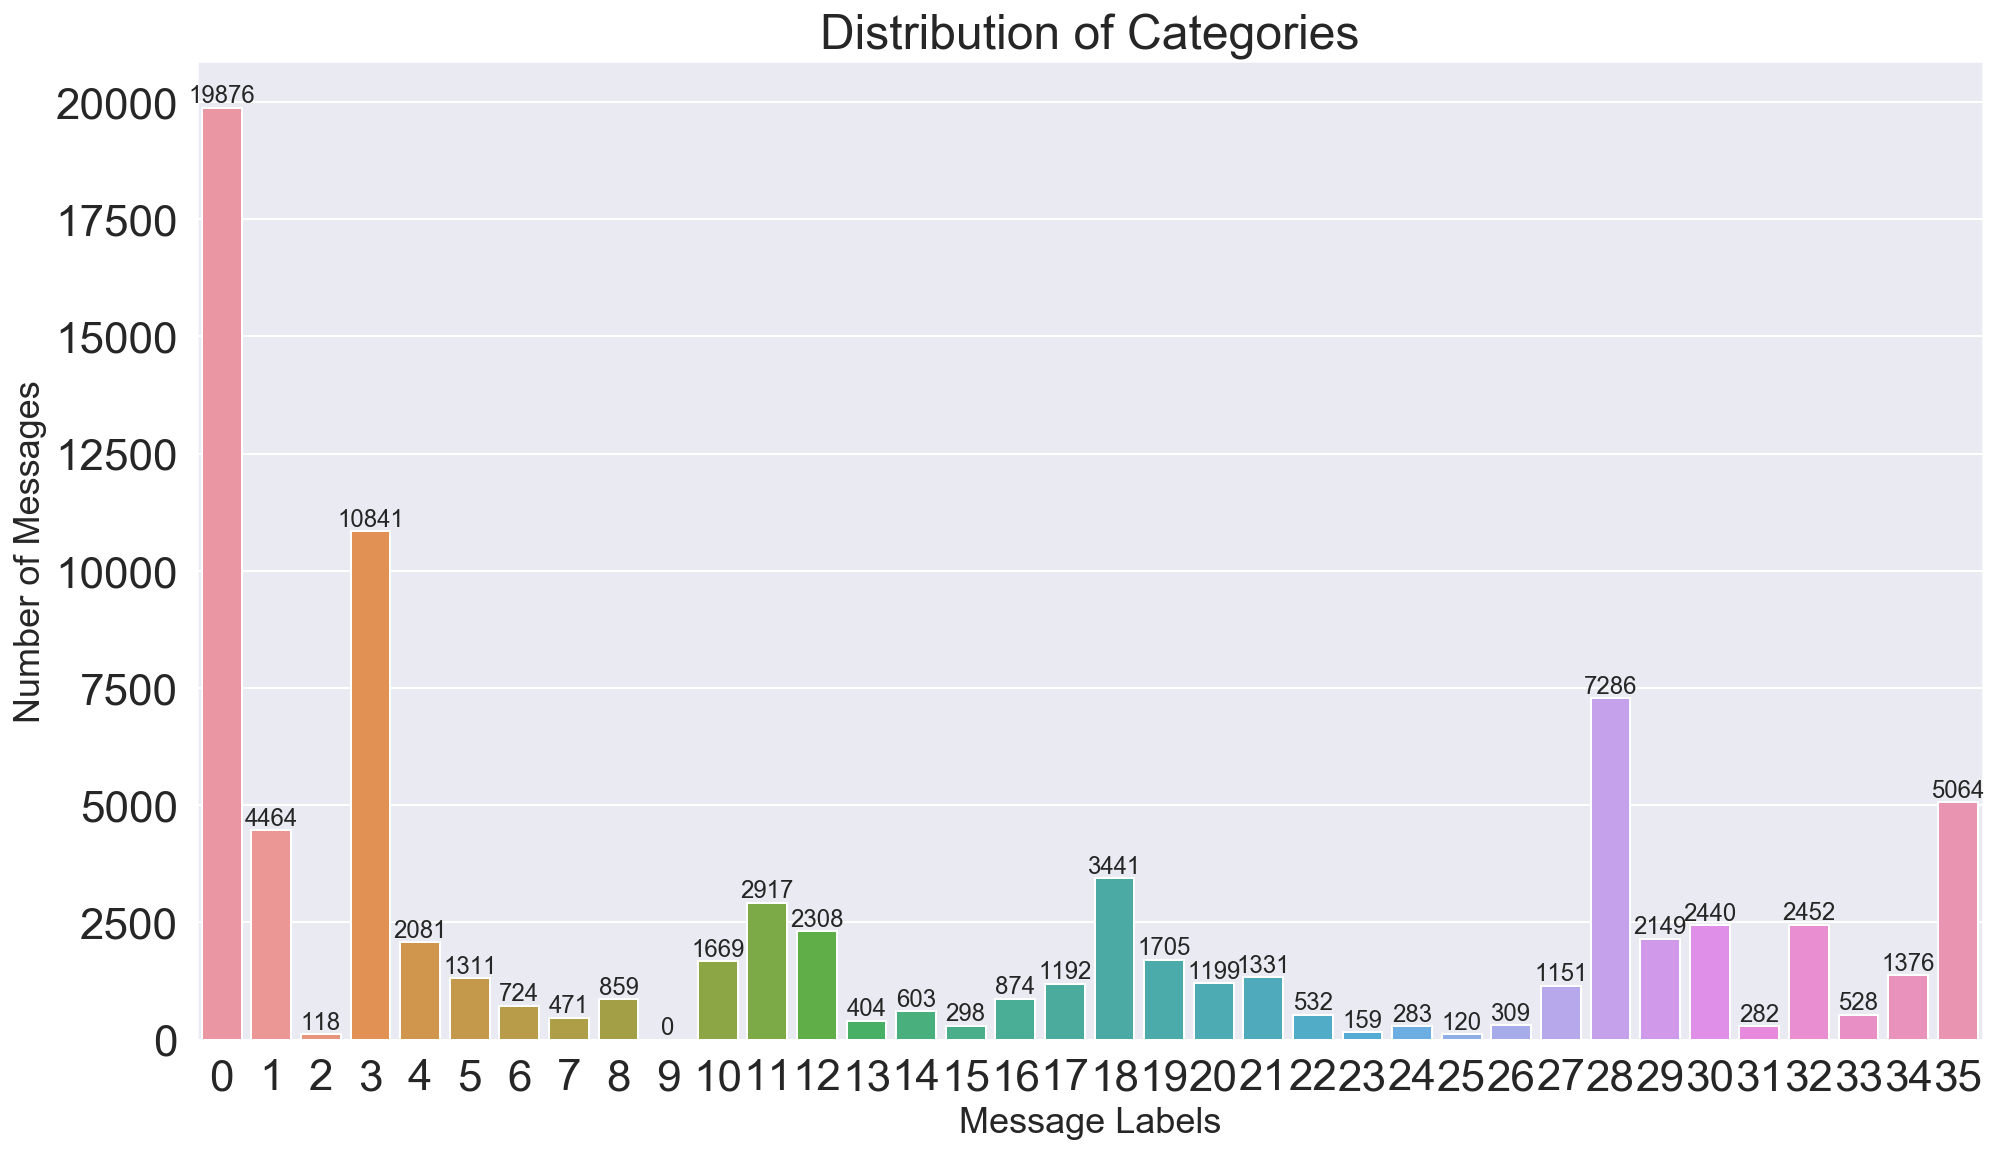

In [108]:
cats = list(range(categories.shape[1])) # replace the name of categories into numbers
counts = categories.sum().values
sns.set(font_scale = 2)
plt.figure(figsize=(16,9))
ax= sns.barplot(cats, counts)
plt.title("Distribution of Categories", fontsize=24)
plt.ylabel('Number of Messages', fontsize=18)
plt.xlabel('Message Labels', fontsize=18)
#adding the text labels
rects = ax.patches
for rect, count in zip(rects, counts):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, count, ha='center', va='bottom', fontsize=12)
plt.show()

We can see that several message types are very rare, i.e., the data set is highly imbalanced. There is even a category (#9, 'child_alone') coming without any positive labels at all! 
Let's pull the names of all imbalanced set:

Here we define the imbalanced set as the ratio of positive or negative labels over the whole dataset exceeding a critical value, say 95%.

In [73]:
# less than 5% of data are positive or negative lables
criteria_1 = counts/categories.shape[0] < 0.05
criteria_2 = counts/categories.shape[0] > 0.95
np.concatenate([categories.columns.values[criteria_1], categories.columns.values[criteria_2]])

array(['offer', 'search_and_rescue', 'security', 'military',
       'child_alone', 'clothing', 'money', 'missing_people', 'refugees',
       'death', 'transport', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'fire', 'cold'],
      dtype=object)

This huge imbalance will create a lot of difficulty in our ML modeling. Before we move on, we first drop the empty column 'child_alone' found above

In [109]:
# delete the empty column
df = df.drop(columns = 'child_alone')
categories = df.drop(columns = ['id', 'message', 'original', 'genre'])

Next we inspect the distribution of multilabels, i.e., how many labels do one message get?

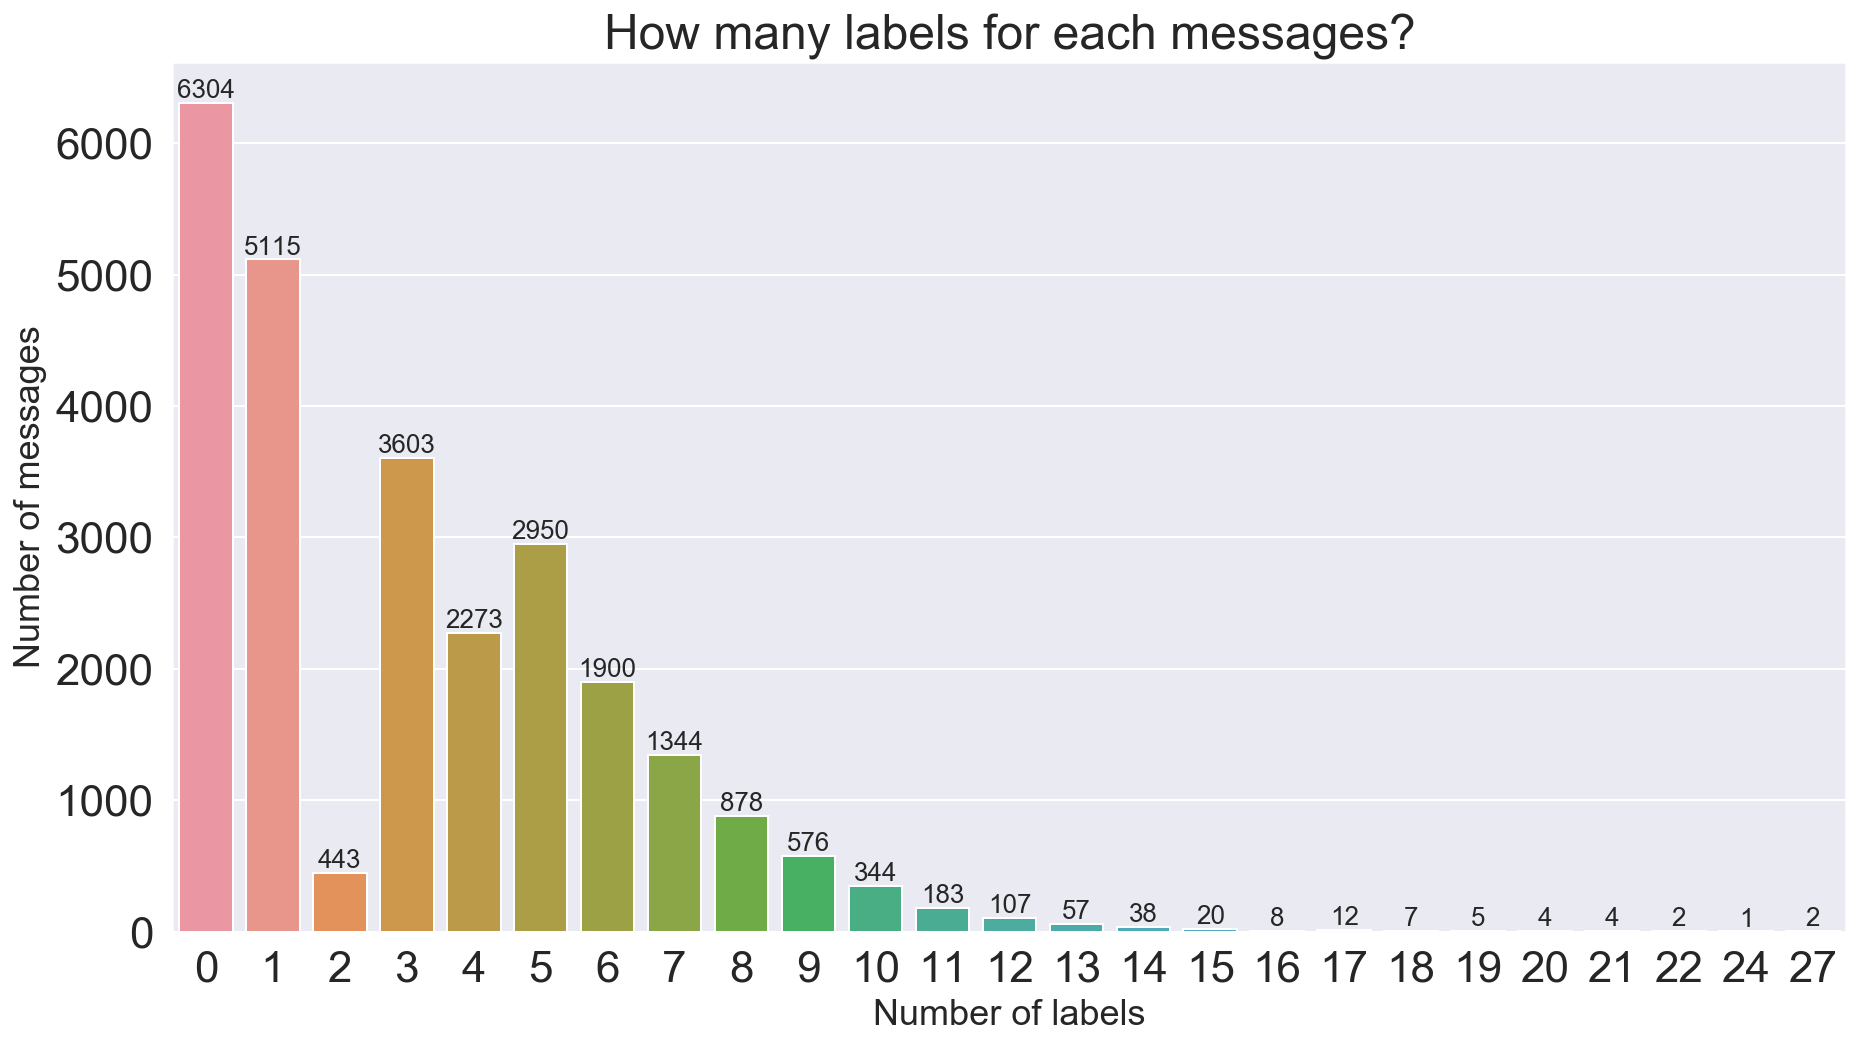

In [110]:
rowsums = categories.sum(axis=1)
multilabel_counts = rowsums.value_counts().sort_index()
# multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multilabel_counts.index, multilabel_counts.values)
plt.title("How many labels for each messages?")
plt.ylabel('Number of messages', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multilabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height, label, ha='center', va='bottom', fontsize=13)
plt.show()

Except for an outlier 2, the rest of the data clearly shows the trend that multi-labeled messages are uncommon. And over 23% of the messages even don't have any positive labels. 

For those with messages with one label, we can check that the only label they get is 'related' = 1.

In [79]:
# the sum of all other labels for those with total label # 1
related_check_1 = categories.loc[(rowsums == 1).values].drop(columns = 'related').sum(axis=1)
related_check_1.sum()

0

So based on the number of labels that these messages get, we find that a message is first classified as 'related' or not. If related, then it is further classified into some subcategories. But a large number of related messages do not fall into any of these subcategories and remain unclassified.

For those messages which do get further classified, they are likely to get multiple tags because these 35 sub-fields are not mutually exclusive. Hence it explains why the number of messages with two labels are so rare. We can check that one of the labels these messages get is 'related' = 1 

In [80]:
# total number of messages with 2 labels
label_num_2 = (rowsums == 2).sum() 
# for those double-labeled messages, how many 'related' = 1 they got
label_num_2_related_1 = df.loc[rowsums[rowsums == 2].index].related.sum()
# these two numbers equal
label_num_2 == label_num_2_related_1

True

### 6. Remove duplicates.
- Check how many duplicates are in this dataset.
- Drop the duplicates.
- Confirm duplicates were removed.

In [ ]:
# check number of duplicates
df[df.duplicated(subset = 'id', keep=False)]

### 7. Save the clean dataset into an sqlite database.
You can do this with pandas [`to_sql` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_sql.html) combined with the SQLAlchemy library. Remember to import SQLAlchemy's `create_engine` in the first cell of this notebook to use it below.

In [ ]:
from sqlalchemy import create_engine
path = 'data/DisasterResponse'
engine = create_engine('sqlite:///{}'.format(path))
df.to_sql('RawDataClean', engine, if_exists = 'replace', index=False)
engine.dispose()

### 8. Use this notebook to complete `etl_pipeline.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database based on new datasets specified by the user. Alternatively, you can complete `etl_pipeline.py` in the classroom on the `Project Workspace IDE` coming later.